## An introduction to working with the Cadence Simulations for the AGN SC
**By:** Weixiang Yu, Gordon Richards

This notebook provides a somewhat simplified crash-course to the [project's "official" crash-course overview](https://github.com/LSST-nonproject/sims_maf_contrib/blob/master/tutorials/Introduction%20Notebook.ipynb), primarily for use within the [SciServer.org](http://sciserver.org) environment.

__Update:__
There are a new set of tutorial notebooks to accommodate the release of the $\texttt{rubin_sim}$ package, you can find them at [rubin_sim_notebooks](https://github.com/lsst/rubin_sim_notebooks) on github.

<!-- <b>Now we can start computing metrics to use for comparing different opSims.</b> -->

### Software Setup (repeat each session)

In [251]:
# import common python packages
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import os, sys
from os.path import splitext, basename

##### Detect and Set Your SciServer Username
__Note:__ Your usename will be used to store MAF output, so please make sure it is correct.

In [2]:
your_username = os.getcwd().split('/')[5]
print(f'Your automatically extracted username is: {your_username}.'
    ' If it is incorrect, please mannually reset it.')

Your automatically extracted username is: ywx649999311. If it is incorrect, please mannually reset it.


##### Import the $\texttt{rubin_sim}$ modules needed.

In [3]:
# import rubin_sim python modules
import rubin_sim.maf.db as db
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.stackers as stackers
import rubin_sim.maf.plots as plots
import rubin_sim.maf.metricBundles as metricBundles

# print version
import rubin_sim
rubin_sim.__version__

'0.10.1.dev62+gbb0801e'

In [4]:
from opsimUtils import *

In [5]:
#Read in an opSim (in this case "baseline_v1.5_10yrs.db")
opsdb1 = db.OpsimDatabase('/home/idies/workspace/lsst_cadence/fbs2/sim_dbs/baseline_v2.0_10yrs.db')

outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/tmp'.format(your_username)
resultsDb = db.ResultsDb(outDir=outDir)

In [6]:
metric = metrics.Coaddm5Metric()
constraint = 'filter = "r"'
slicer = slicers.HealpixSlicer(nside=64)
# constraint2 += ' and note not like "DD%"' # added so the sky plot won't saturate (remove DDFs)

coAddR = metricBundles.MetricBundle(metric, slicer, constraint)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [7]:
healpixSky = plots.HealpixSkyMap()
plot_funcs = [healpixSky]
plot_dicts = {'left':1, 'right':2.8}

In [8]:
coAddR = metricBundles.MetricBundle(metric, slicer, constraint,
                                    plotFuncs=plot_funcs, plotDict=plot_dicts, \
                                    runName='baseline_v2.0_10yrs')
bundleDict = {'coAddR': coAddR}

In [9]:
group = metricBundles.MetricBundleGroup(bundleDict, opsdb1, 
                                        outDir=outDir, resultsDb=resultsDb)

In [10]:
group.runAll()

Querying table None with constraint filter = "r" for columns ['fieldRA', 'rotSkyPos', 'fieldDec', 'fiveSigmaDepth']
Found 464851 visits
Running:  ['coAddR']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


/home/idies/miniconda3/envs/rubin/lib/python3.10/site-packages/healpy/newvisufunc.py:397: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': 0, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/idies/miniconda3/envs/rubin/lib/python3.10/site-packages/healpy/newvisufunc.py:401: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.5, 'cbar_pad': 0.05, 'cbar_label_pad': 0, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")


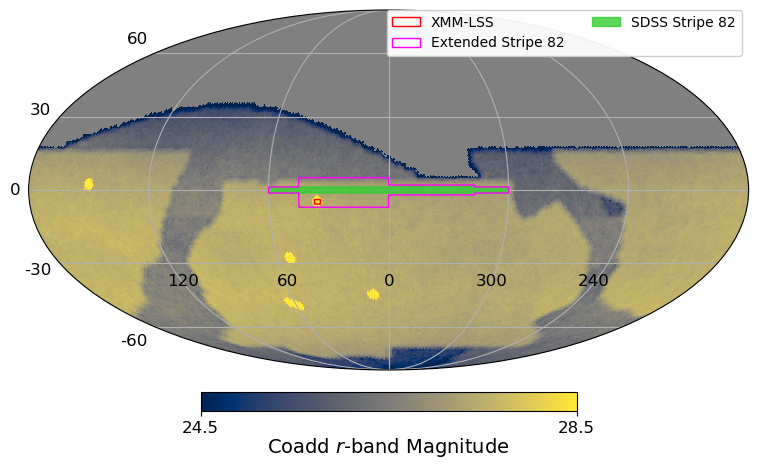

In [382]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 8))
fig = plt.figure(figsize=(8, 5))

maxVal, minVal = (27.5, 25)
mb = bundleDict['coAddR']
scale_func = np.array

try:
    mbValues = mb.metricValues.copy()
    mask = mbValues.mask
    dirty_data = mbValues.data[~mask]
    data = dirty_data[~(np.isnan(dirty_data) | np.isinf(dirty_data))]
    nData = data
except Exception as e:
    print(e)
#     return None
    
if maxVal is None:
    maxVal = np.percentile(nData, 99)
if minVal is None: 
    minVal = np.percentile(nData, 1)

_ = hp.newvisufunc.projview(mbValues, fig=fig, flip='astro', title='',
                            max=maxVal, min=minVal, 
                            graticule=True, graticule_labels=True, projection_type='mollweide',
                            fontsize={'cbar_label':14, 'cbar_tick_label':12},
                            cbar_ticks=[24.5, 28.5],
                            reuse_axes=True, cmap='cividis',
                            custom_ytick_labels = [-60, -30, 0, 30, 60],
                            override_plot_properties = {'cbar_shrink':0.5},
                            extend='neither', alpha=1
                            )
    
# fine tune
f = fig.get_children()
# adjust color bar
CbAx = f[2]
CbAx.set_xlabel('Coadd $r$-band Magnitude')

# move tick label up
HpxAx = f[1]
HpxAx.xaxis.set_tick_params(labelbottom=0)
HpxAx.text(-2-0.28, -0.7, '120', fontsize=12)
HpxAx.text(-1-0.15, -0.7, '60', fontsize=12)
HpxAx.text(-0.045,-0.7, '0', fontsize=12)
HpxAx.text(1-0.1, -0.7, '300', fontsize=12)
HpxAx.text(2-0.05, -0.7, '240', fontsize=12)


# plot DC bounds
xmm_lss_bound = [[-34.2, -5.72], [-34.2, -3.87], [-37.125, -3.87], [-37.125, -5.72]]
xmm_lss_polygon = Polygon(np.radians(xmm_lss_bound), closed=True,
                         fill=False, edgecolor='r', linewidth=1,
                         label='XMM-LSS', zorder=100)

# extended stripe 82
s82_bound = [[-60, -1.25], [-60, 1.25], [-43, 1.25], [-43, 2], 
            [0, 2], [0, 5], [45, 5], [45, 1.25], [60, 1.25],
            [60, -1.25], [45, -1.25], [45, -7], [0, -7], [0, -2],
            [-43, -2], [-43, -1.25], [-60, -1.25]]
s82_bound = [[-x[0], x[1]] for x in s82_bound]
s82_polygon = Polygon(np.radians(s82_bound), closed=True, 
                      fill=False, edgecolor='magenta', linewidth=1,
                      label='Extended Stripe 82', zorder=100)
# sdss stripe 82
sdss_s82_bound = [[-60, -1.25], [-60, 1.25], [60, 1.25], [60, -1.25]]
sdss_s82_polygon = Polygon(np.radians(sdss_s82_bound), closed=True, 
                      facecolor='limegreen', edgecolor='limegreen',
                      alpha=.8, label='SDSS Stripe 82', zorder=80)

a = HpxAx.add_patch(xmm_lss_polygon)
b = HpxAx.add_patch(s82_polygon)
c = HpxAx.add_patch(sdss_s82_polygon)

HpxAx.legend(handles=[a, b, c], loc=1, bbox_to_anchor=[1, 1.02], ncol=2, 
             framealpha=.95, fontsize=10)
plt.savefig('agndc_fp.pdf')